c:\Users\lewy7\Documents\GitHub\MIKO Contest\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2943544.26it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 264366.04it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2472131.39it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4452098.33it/s]
c:\Users\lewy7\Documents\GitHub\MIKO Contest\venv\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



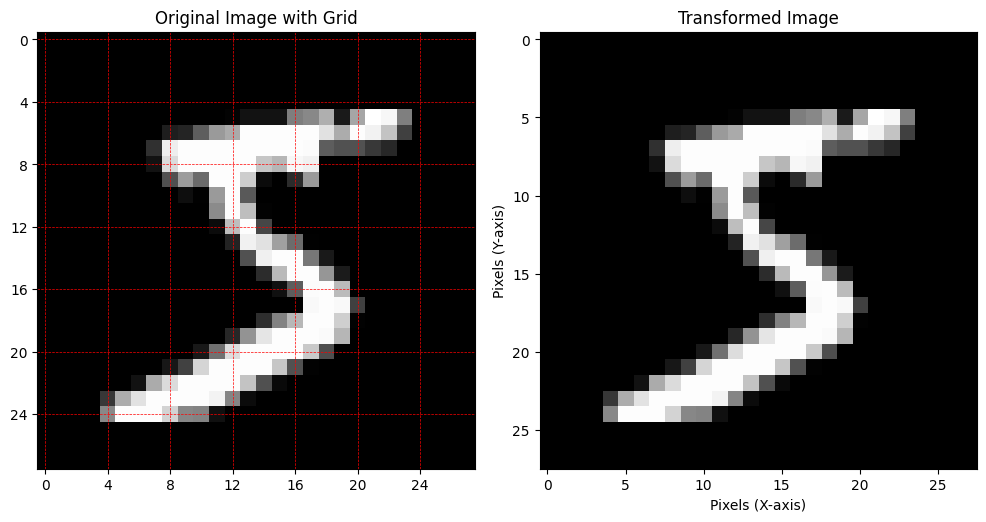

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

# Load a sample image from MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# Get a single image (28x28)
image, label = mnist[0]
image = image.squeeze(0)  # Remove the channel dimension (1x28x28 -> 28x28)

# Define the affine transformation matrix (2x3)
def apply_affine_transformation(image, matrix, grid_spacing=4):
    """
    Apply affine transformation to an MNIST image using matrix multiplication.

    Args:
        image (torch.Tensor): Input image (H, W).
        matrix (torch.Tensor): 2x3 affine transformation matrix.
        grid_spacing (int): Spacing for grid visualization.

    Returns:
        transformed_image (torch.Tensor): Transformed image (H, W).
    """
    H, W = image.shape

    # Create normalized coordinates for the output image
    y_coords, x_coords = torch.meshgrid(torch.linspace(-1, 1, H), torch.linspace(-1, 1, W))
    coords = torch.stack([x_coords, y_coords, torch.ones_like(x_coords)], dim=2).reshape(-1, 3).T  # (3, H*W)

    # Apply the affine transformation
    transformed_coords = torch.matmul(matrix, coords).T  # (H*W, 2)

    # Reshape transformed coordinates back into grid format
    transformed_coords = transformed_coords.reshape(H, W, 2)

    # Map normalized coordinates to input image space using grid_sample
    transformed_image = F.grid_sample(
        image.unsqueeze(0).unsqueeze(0),  # Add batch and channel dimensions
        transformed_coords.unsqueeze(0),  # Add batch dimension
        align_corners=True,
        mode='bilinear',
        padding_mode='zeros',
    )
    transformed_image = transformed_image.squeeze(0).squeeze(0)  # Remove batch and channel dimensions

    # Visualize the grid overlay on the original image
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Original image with grid
    ax[0].imshow(image.numpy(), cmap="gray")
    ax[0].set_title("Original Image with Grid")
    ax[0].set_xticks(np.arange(0, W, grid_spacing))
    ax[0].set_yticks(np.arange(0, H, grid_spacing))
    ax[0].grid(color='red', linestyle='--', linewidth=0.5)

    # Transformed image
    ax[1].imshow(transformed_image.detach().numpy(), cmap="gray")
    ax[1].set_title("Transformed Image")
    ax[1].set_xlabel("Pixels (X-axis)")
    ax[1].set_ylabel("Pixels (Y-axis)")

    plt.tight_layout()
    plt.show()

# Example transformation matrix (you can edit this)
transformation_matrix = torch.tensor([
    [5.0, 2.0, 1.0],  # No scaling, no rotation, no translation in x
    [2.0, 5.0, 0.0]   # No scaling, no rotation, no translation in y
])

# Try adding scaling, translation, or rotation:
# - Scaling: Change the diagonal elements (e.g., [1.2, 1.2, 0.0])
# - Translation: Change the last column (e.g., [0.0, 0.0, 0.5])
# - Rotation: Use cos(theta) and sin(theta) to fill the matrix

apply_affine_transformation(image, transformation_matrix)
